In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.stats as stat
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import pickle
from sklearn.metrics import *
import pandas as pd
import seaborn as sns
sns.set_theme()
import statsmodels

In [2]:
from all_models import *

In [3]:
# read fit values
fits_single = pickle.load(open('fit_single_CV_704.pickle', 'rb'))
fits_dual = pickle.load(open('fit_dual_CV_704.pickle', 'rb'))
fits_six = pickle.load(open('fit_six_CV_704.pickle', 'rb'))
fits_mixed = pickle.load(open('fit_mixed_CV_704.pickle', 'rb'))


curvatures_smooth = pickle.load(open('curvatures_smooth.pickle', 'rb'))
curvatures_smooth = curvatures_smooth/90.0
curvatures = pickle.load(open('curvatures.pickle', 'rb'))

In [12]:
sp = pickle.load(open('sp.pickle', 'rb'))
sp.shape
sp[2][0]

0

In [15]:
starting_points = np.zeros((100, 60), dtype = object)
ti = np.zeros((100, 60), dtype = object)
for i in range(100):
    for participant in range(60):
        ti[i][participant] = fits_dual[i][participant][-1]
        starting_points[i][participant] = np.hstack((fits_dual[i][participant][:2],fits_dual[i][participant][:2], fits_dual[i][participant][2:4], fits_dual[i][participant][-2]))


In [16]:
pickle.dump(ti, open('ti.pickle', 'wb'))
pickle.dump(starting_points, open('sp.pickle', 'wb'))


In [77]:
starting_points[0][0]

array([array([8.81961383e-09]), array([0.0235135]),
       array([8.81961383e-09]), array([0.0235135]),
       array([4.0029126e-05]), array([0.02349156]), 0.14334898884702604],
      dtype=object)

In [4]:
def plot_data_vs_fits_dual(curvatures_smooth, Af, Bf, As, Bs):
    plt.figure(figsize = (20, 10))
    errors_predict = np.zeros((60, 704))
    fast = np.zeros((60, 704))
    slow = np.zeros((60, 704))
    rotation_est = np.zeros((60, 704))
    corr_coef = np.zeros(60)
    for participant in range(60):
        if participant % 4 == 0 or participant%4 == 1:
            errors_predict[participant], rotation_est[participant], fast[participant], slow[participant] = dual_model_sudden(704, Af[participant], Bf[participant], As[participant], Bs[participant])
            corr_coef[participant] = np.ma.corrcoef(errors_predict[participant], np.ravel(curvatures_smooth[participant])[64:])[0, 1]
        else:    
            errors_predict[participant], rotation_est[participant], fast[participant], slow[participant] = dual_model_gradual(704, Af[participant], Bf[participant], As[participant], Bs[participant])
            corr_coef[participant] = np.ma.corrcoef(errors_predict[participant], np.ravel(curvatures_smooth[participant])[64:])[0, 1]

    fig, ax = plt.subplots(4, dpi = 300, sharex = True, constrained_layout = True, figsize = (25, 15))
    plt.setp(ax, ylim=(-1, 2))
    legend_size = 15
    for participant in range(4):
        if participant%4 == 0  or participant%4 == 1:
            #plt.plot(np.nanmean(errors_predict[participant::4], axis = 0))
            l1, = ax[participant].plot(np.nanmean(rotation_est[participant::4], axis = 0))
            l2, = ax[participant].plot(np.nanmean(fast[participant::4], axis = 0))
            l3, = ax[participant].plot(np.nanmean(slow[participant::4], axis = 0))
            l4, = ax[participant].plot(np.append(np.ravel(np.nanmean(1 - curvatures_smooth[participant::4], axis = 0)[1:-1]), np.ravel(np.nanmean(curvatures_smooth[participant::4], axis = 0)[11])))
            ax[participant].legend([l1, l2, l3, l4], ['Rotation Est', 'Fast Est', 'Slow Est', 'Rotation Est Data'], prop={'size': legend_size})
        else:
            l1, = ax[participant].plot(np.nanmean(rotation_est[participant::4], axis = 0))
            l2, = ax[participant].plot(np.nanmean(fast[participant::4], axis = 0))
            l3, = ax[participant].plot(np.nanmean(slow[participant::4], axis = 0))
            cs = np.zeros((704))
            csm = np.nanmean(curvatures_smooth[participant::4], axis = 0)
            for i in range(9):
                cs[i*64:(i+1)*64] = (i+1)*10/90.0 - csm[i+1]
            cs[576:640] = 1 - csm[10]
            cs[640:] = csm[11]
            l4, = ax[participant].plot(cs)
            #plt.plot(np.append(np.ravel(np.nanmean(90 - curvatures_smooth[participant::4], axis = 0)[1:-1]), -np.ravel(np.nanmean(curvatures_smooth[participant::4], axis = 0)[11])))
            ax[participant].legend([l1, l2, l3, l4], ['Rotation Est', 'Fast Est', 'Slow Est', 'Rotation Est Data'], prop = {'size' : legend_size})


        ax[participant].plot(np.zeros(704), color = 'black')
        ax[0].set_ylabel('Sudden \n Speed', fontsize = 15)
        ax[1].set_ylabel('Sudden \n Accuracy', fontsize = 15)
        ax[2].set_ylabel('Gradual \n Speed', fontsize = 15)
        ax[3].set_ylabel('Gradual \n Accuracy', fontsize = 15)
    fig.suptitle('Dual Model Predictions', fontsize = 20)
    return corr_coef


array([ 0.56209058,  0.81261183,  0.72413891,  0.72308079,  0.48483711,
        0.61579528,  0.62484342,  0.80844488,  0.52398618,  0.57908606,
        0.52484274,  0.77648151,  0.77089694,  0.82624121,  0.72867308,
        0.49558503,  0.03535925,  0.69187477,  0.68321395,  0.70215525,
        0.15663434,  0.87349005,  0.29022983,  0.64545218,  0.47007961,
        0.75833504,  0.42533895,  0.41511072,  0.45686462,  0.68217275,
        0.66246837,  0.71196551,  0.36966881, -0.17057924,  0.44125215,
        0.66692925,  0.59777442,  0.50086913,  0.56094064,  0.59684547,
        0.95758   ,  0.7022373 ,  0.27565272,  0.59213494,  0.84232519,
        0.42547856,  0.65683813,  0.74930948,  0.57319032,  0.63730962,
        0.54076978,  0.57854006,  0.58502814,  0.37125641,  0.33880237,
        0.55399039,  0.58952601,  0.55035596,  0.68559706,  0.68004743])

<Figure size 1440x720 with 0 Axes>

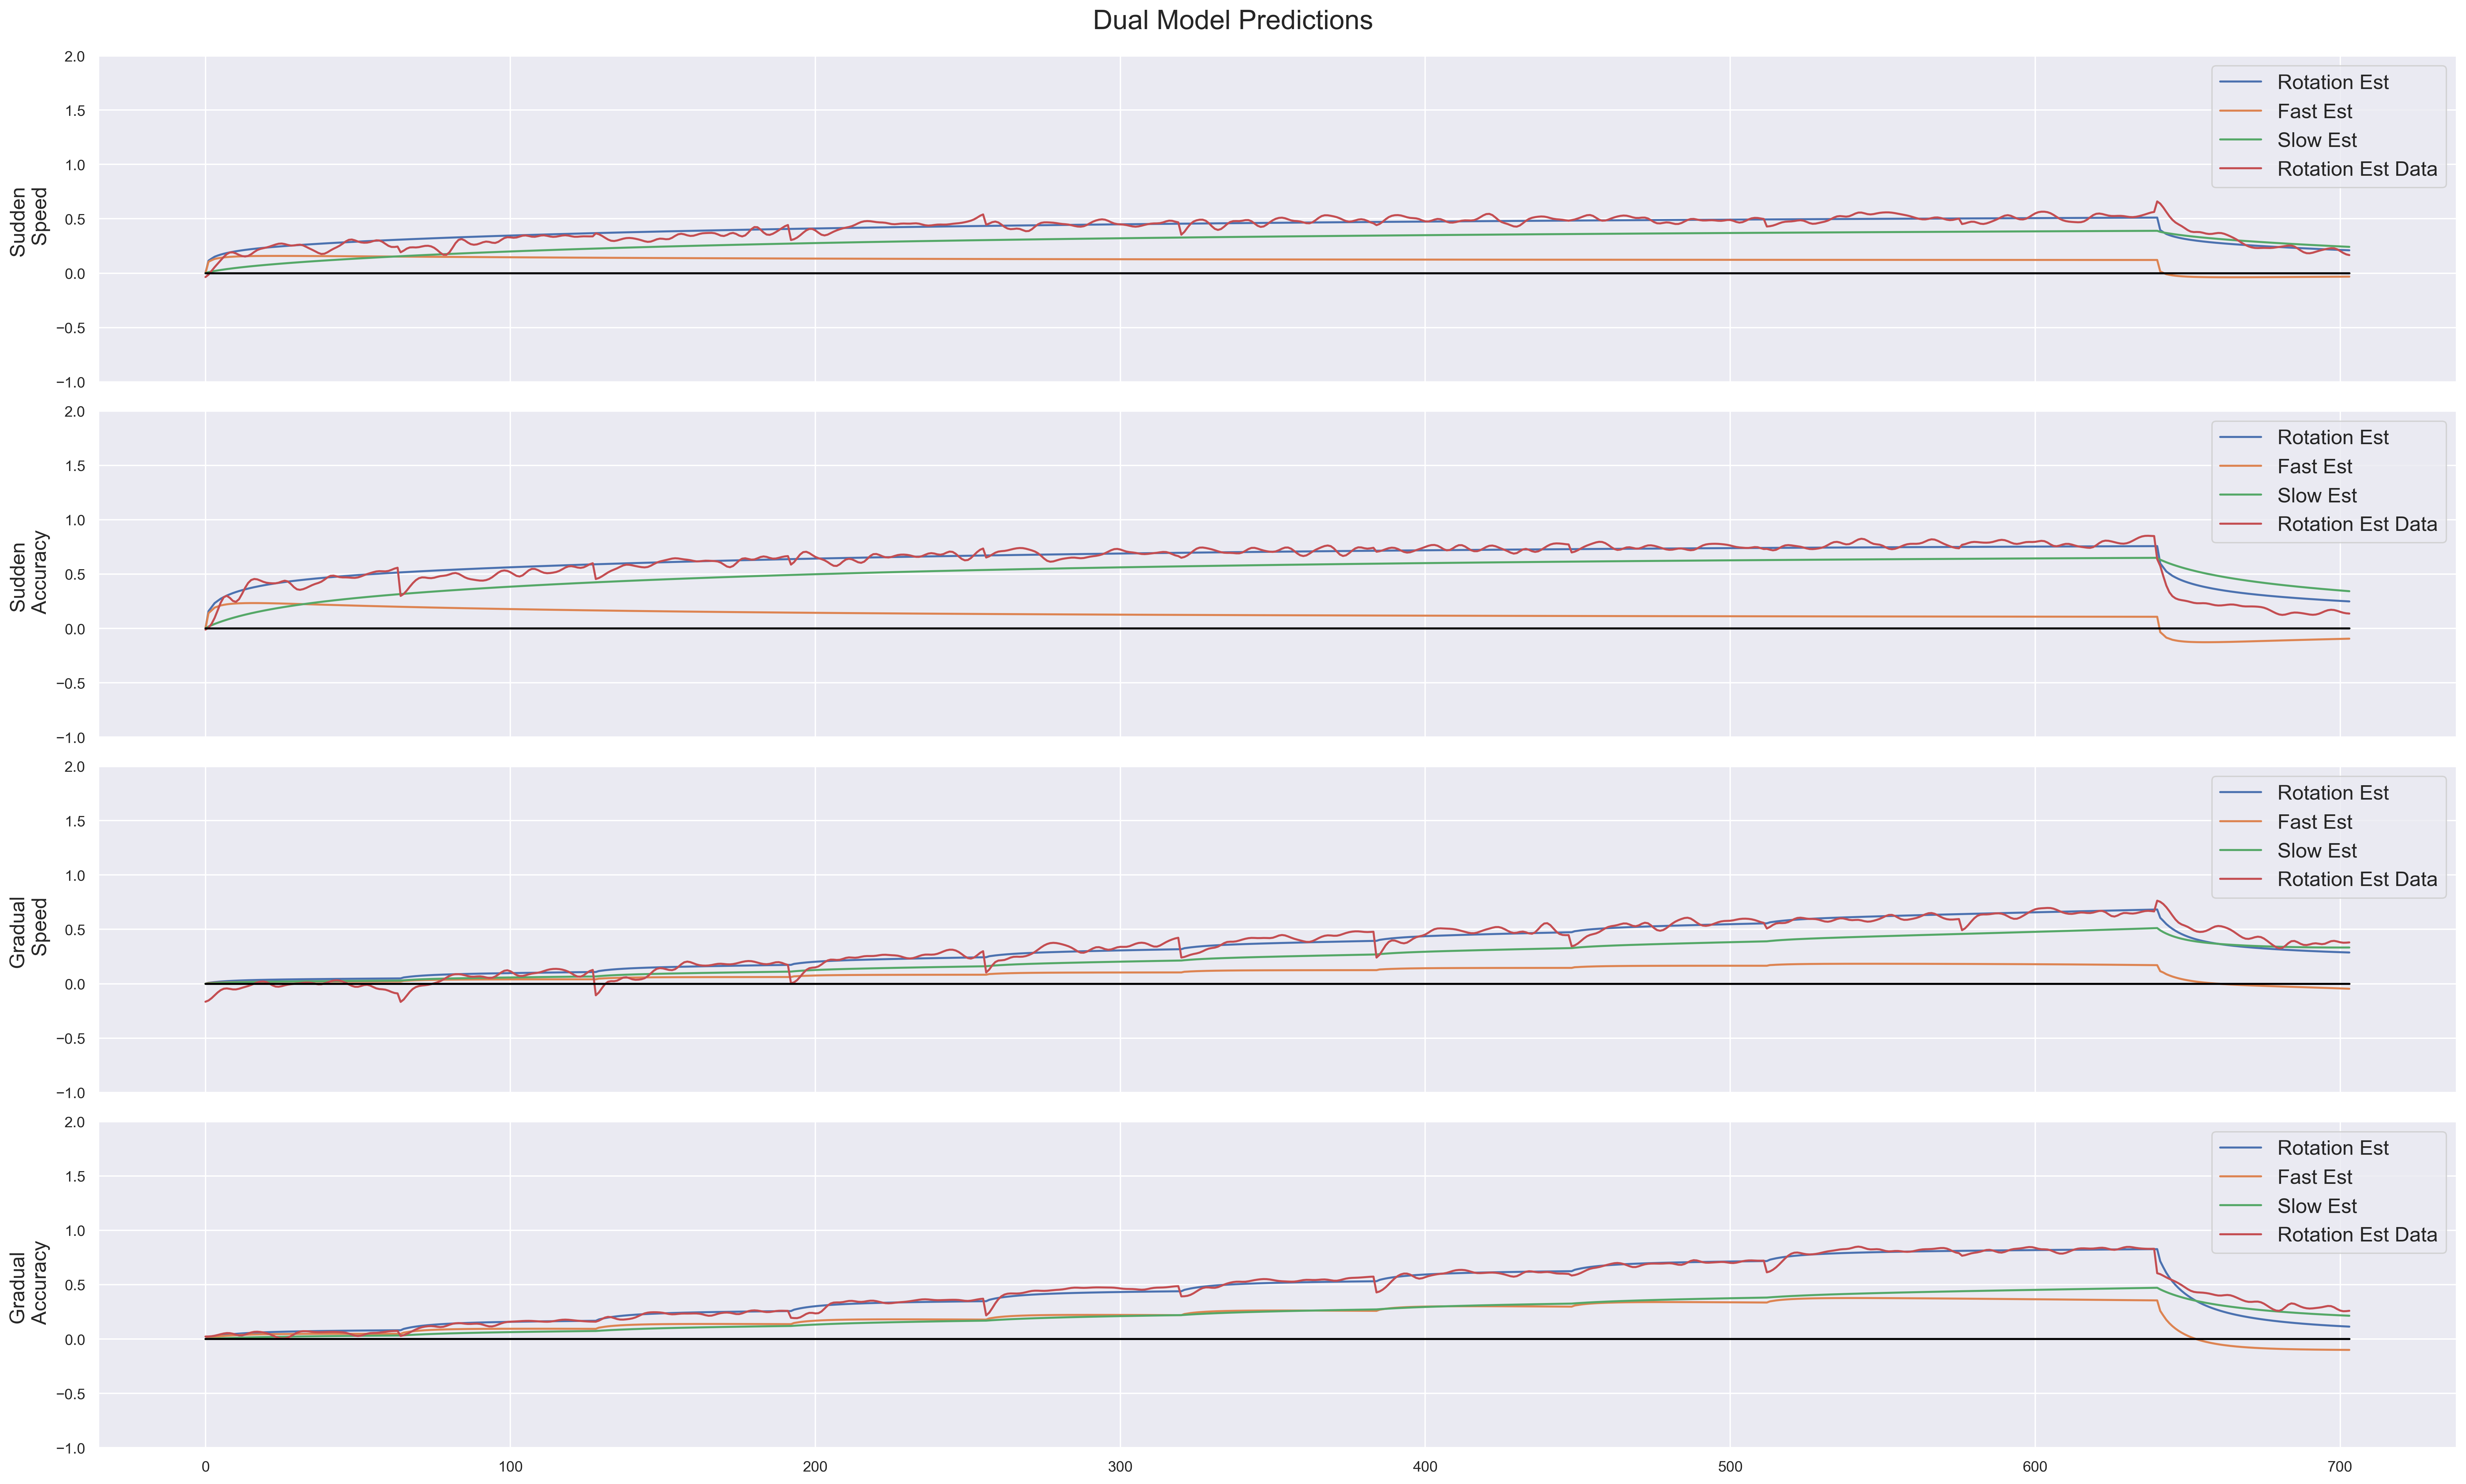

In [8]:
plot_data_vs_fits_dual(curvatures_smooth, fits_dual[:, 0], fits_dual[:, 1], fits_dual[:, 2], fits_dual[:, 3])

In [9]:
def plot_data_vs_fits_single(curvatures_smooth, A, B):
    plt.figure(figsize = (20, 10))
    errors_predict = np.zeros((60, 704))
    fast = np.zeros((60, 704))
    slow = np.zeros((60, 704))
    rotation_est = np.zeros((60, 704))
    corr_coef = np.zeros(60)
    for participant in range(60):
        if participant % 4 == 0 or participant%4 == 1:
            errors_predict[participant], rotation_est[participant] = model_sudden(704, A[participant], B[participant])
            corr_coef[participant] = np.ma.corrcoef(errors_predict[participant], np.ravel(curvatures_smooth[participant])[64:])[0, 1]
        else:    
            errors_predict[participant], rotation_est[participant] = model_gradual(704, A[participant], B[participant])
            corr_coef[participant] = np.ma.corrcoef(errors_predict[participant], np.ravel(curvatures_smooth[participant])[64:])[0, 1]

    fig, ax = plt.subplots(4, dpi = 300, sharex = True, constrained_layout = True, figsize = (25, 15))
    plt.setp(ax, ylim=(-1, 2))
    legend_size = 15
    
    for participant in range(4):
        if participant%4 == 0  or participant%4 == 1:
            #plt.plot(np.nanmean(errors_predict[participant::4], axis = 0))
            l1, = ax[participant].plot(np.nanmean(rotation_est[participant::4], axis = 0))
            l4, = ax[participant].plot(np.append(np.ravel(np.nanmean(1 - curvatures_smooth[participant::4], axis = 0)[1:-1]), np.ravel(np.nanmean(curvatures_smooth[participant::4], axis = 0)[11])))
            ax[participant].legend([l1, l4], ['Rotation Est', 'Rotation Est Data'], prop={'size': legend_size})
        else:
            l1, = ax[participant].plot(np.nanmean(rotation_est[participant::4], axis = 0))
            cs = np.zeros((704))
            csm = np.nanmean(curvatures_smooth[participant::4], axis = 0)
            for i in range(9):
                cs[i*64:(i+1)*64] = (i+1)*10/90.0 - csm[i+1]
            cs[576:640] = 1 - csm[10]
            cs[640:] = csm[11]
            l4, = ax[participant].plot(cs)
            #plt.plot(np.append(np.ravel(np.nanmean(90 - curvatures_smooth[participant::4], axis = 0)[1:-1]), -np.ravel(np.nanmean(curvatures_smooth[participant::4], axis = 0)[11])))
            ax[participant].legend([l1, l4], ['Rotation Est', 'Rotation Est Data'], prop = {'size' : legend_size})


        ax[participant].plot(np.zeros(704), color = 'black')
        ax[0].set_ylabel('Sudden \n Speed', fontsize = 15)
        ax[1].set_ylabel('Sudden \n Accuracy', fontsize = 15)
        ax[2].set_ylabel('Gradual \n Speed', fontsize = 15)
        ax[3].set_ylabel('Gradual \n Accuracy', fontsize = 15)
    fig.suptitle('Single state model predictions', fontsize = 20)
    return corr_coef


array([0.56487955, 0.79348189, 0.72370686, 0.73013803, 0.48411188,
       0.59103208, 0.6248567 , 0.81165345, 0.42946698, 0.57677188,
       0.52729028, 0.78742655, 0.7708911 , 0.82175052, 0.75670007,
       0.71065762, 0.04311343, 0.68869799, 0.68236541, 0.68851796,
       0.76583514, 0.86420994, 0.3161819 , 0.61938166, 0.4731492 ,
       0.71943758, 0.42318657, 0.57839378, 0.44720213, 0.6933241 ,
       0.64834394, 0.71906564, 0.44721922, 0.72802552, 0.43401561,
       0.63183436, 0.61163466, 0.42864697, 0.71835497, 0.59544815,
       0.95734592, 0.53626245, 0.29149745, 0.54011365, 0.84363414,
       0.79376287, 0.65682865, 0.77055831, 0.63890805, 0.61643224,
       0.6938231 , 0.57763601, 0.52617737, 0.35101193, 0.35110055,
       0.55395806, 0.64357039, 0.45617648, 0.68614785, 0.65470343])

<Figure size 1440x720 with 0 Axes>

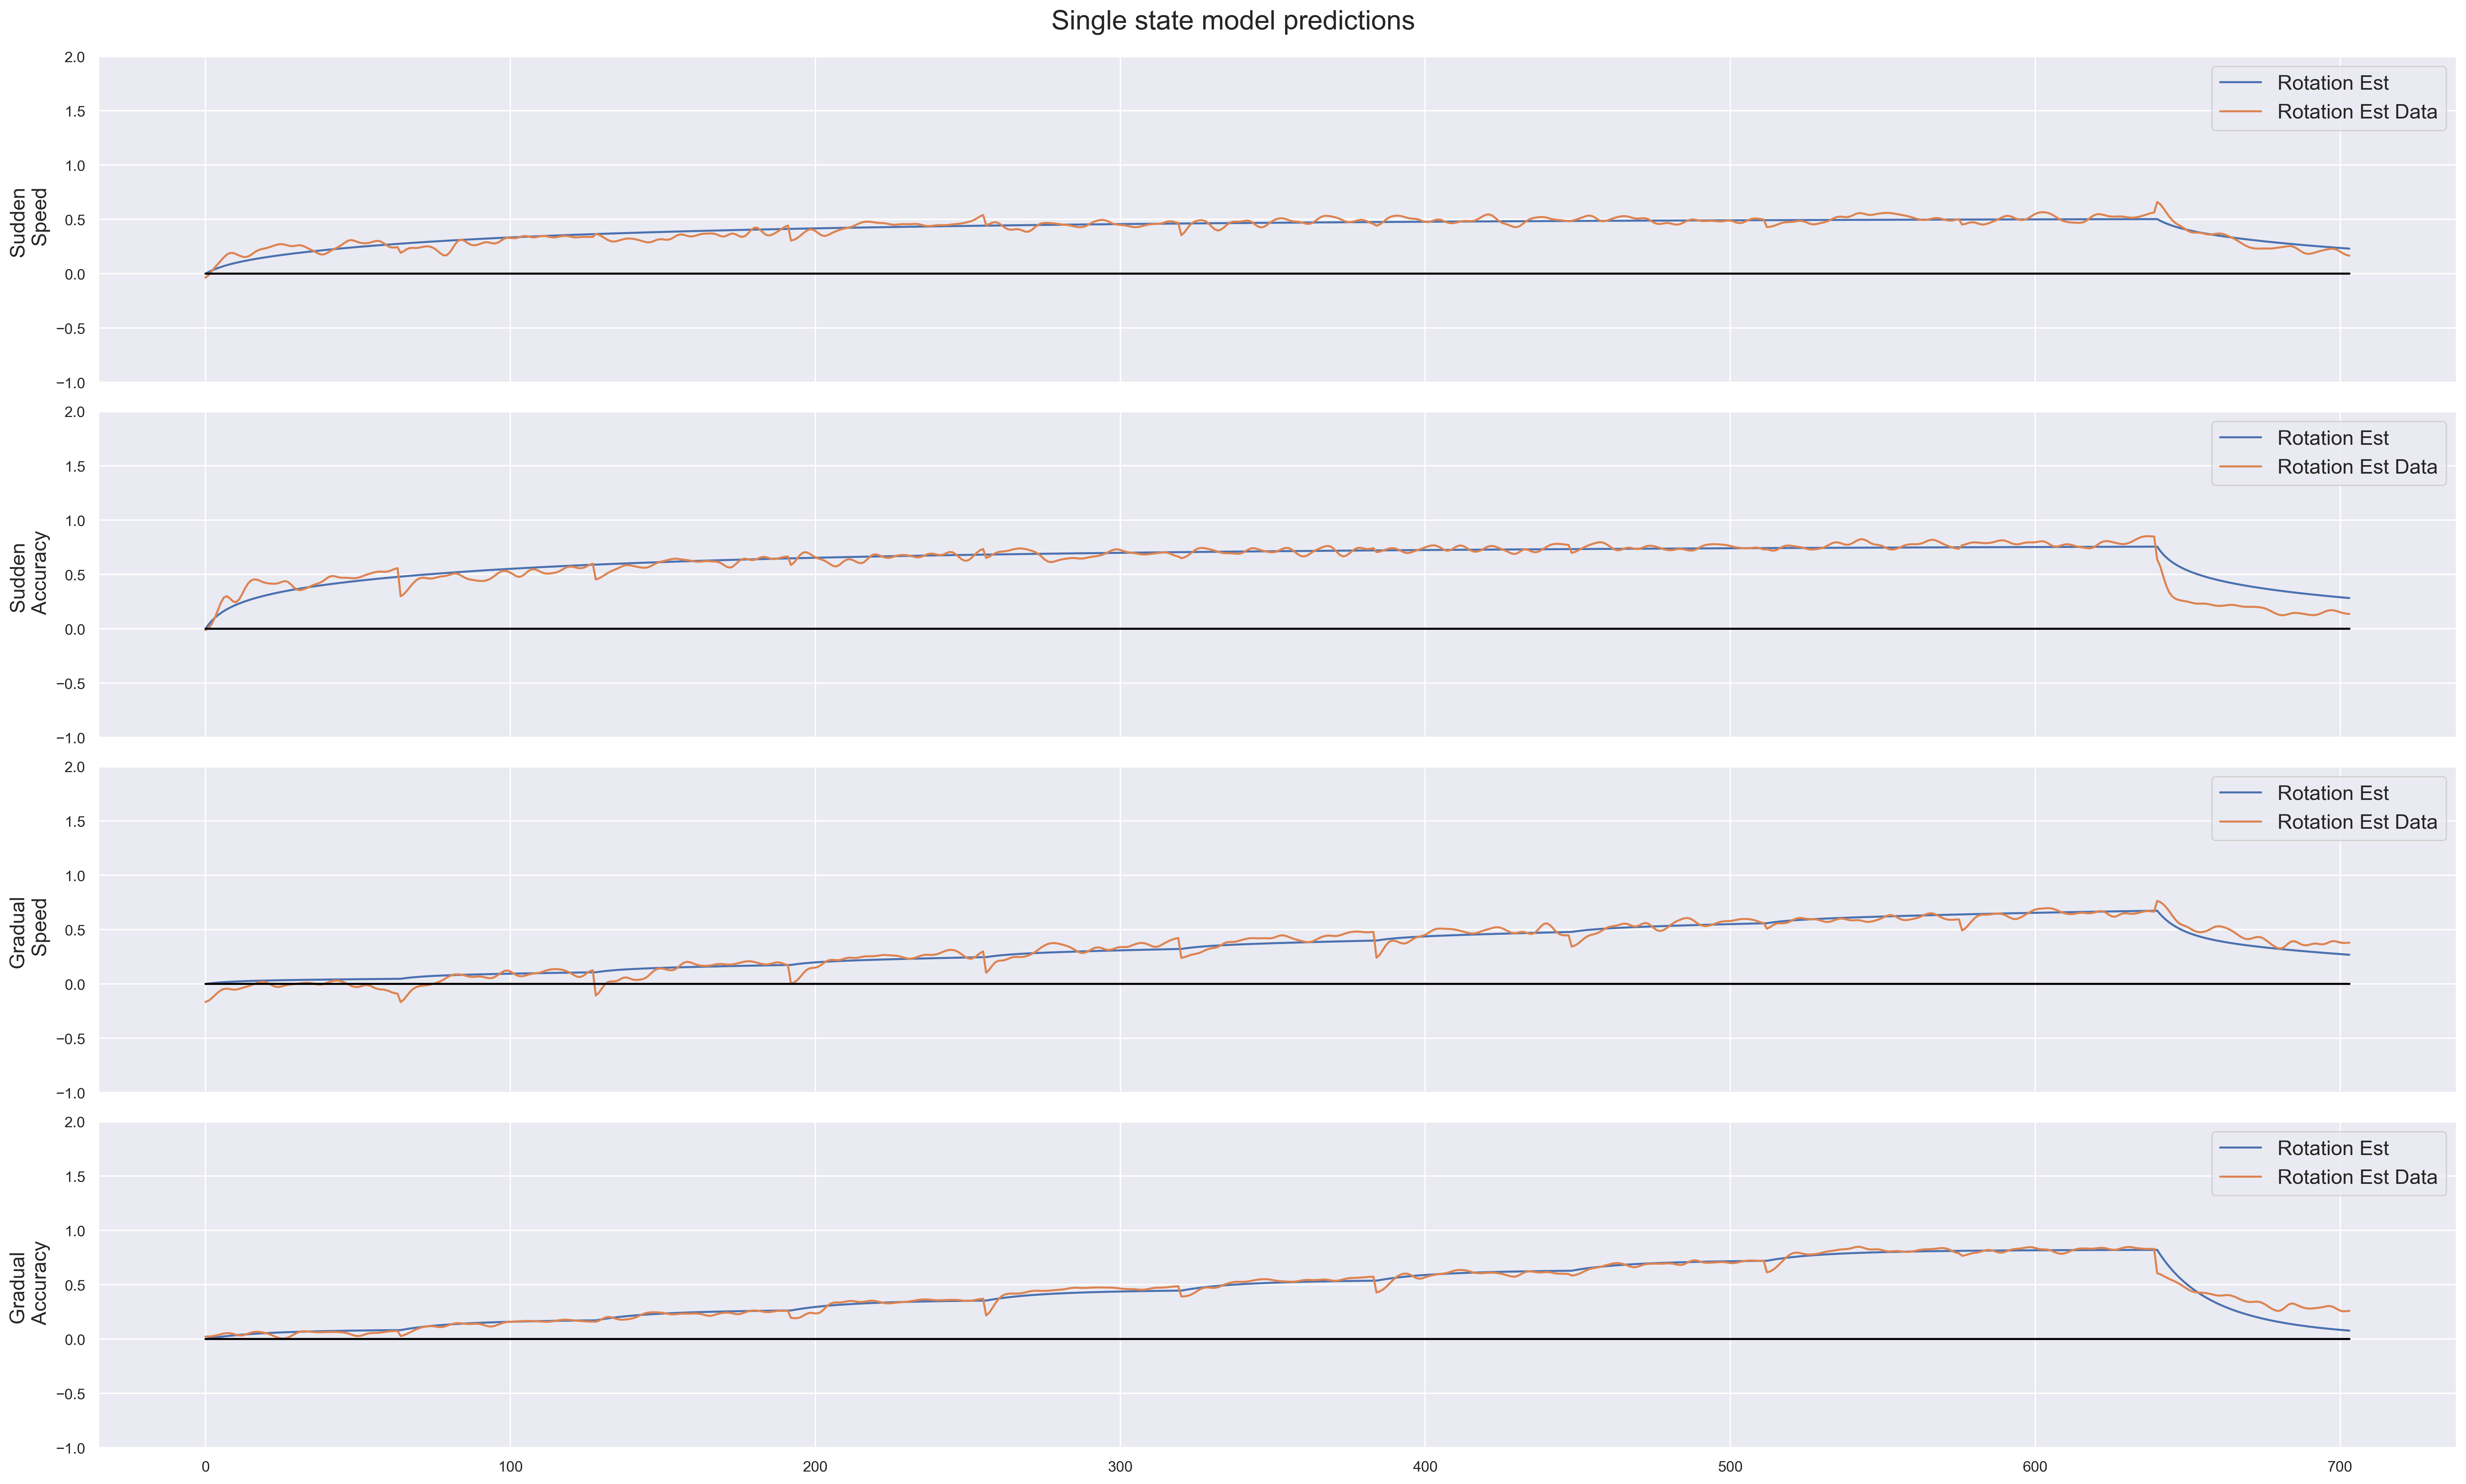

In [10]:
plot_data_vs_fits_single(curvatures_smooth, fits_single[:, 0], fits_single[:, 1])

In [5]:
num_trials = 704
model_errors_dual = np.zeros((100, 60, num_trials))
model_errors_single = np.zeros((100, 60, num_trials))
model_errors_mixed = np.zeros((100, 60, num_trials))
model_errors_six = np.zeros((100, 60, num_trials))

for i in range(100):
    for participant in range(60):
        if participant%4 == 0 or participant%4 == 1:
            model_errors_dual[i][participant]  = dual_model_sudden(num_trials, fits_dual[i][participant][0], fits_dual[i][participant][1], fits_dual[i][participant][2], fits_dual[i][participant][3])[0]
            model_errors_single[i][participant] = model_sudden(num_trials, fits_single[i][participant][0], fits_single[i][participant][1])[0]
            model_errors_mixed[i][participant] = mixed_sudden(num_trials, fits_mixed[i][participant][0], fits_mixed[i][participant][1], fits_mixed[i][participant][2], fits_mixed[i][participant][3])[0]
            model_errors_six[i][participant] = dual_six_param_sudden(num_trials, fits_six[i][participant][0], fits_six[i][participant][1], fits_six[i][participant][2], fits_six[i][participant][3], fits_six[i][participant][4], fits_six[i][participant][5])[0]
            #model_errors_six[i][participant]  = dual_six_param_sudden(num_trials, fits_dual[i][participant][0], fits_dual[i][participant][1], fits_dual[i][participant][0], fits_dual[i][participant][1], fits_dual[i][participant][2], fits_dual[i][participant][3])[0]

        else:
            model_errors_dual[i][participant] = dual_model_gradual(num_trials, fits_dual[i][participant][0], fits_dual[i][participant][1], fits_dual[i][participant][2], fits_dual[i][participant][3])[0]
            model_errors_single[i][participant] = model_gradual(num_trials, fits_single[i][participant][0], fits_single[i][participant][1])[0]
            model_errors_mixed[i][participant] = mixed_gradual(num_trials, fits_mixed[i][participant][0], fits_mixed[i][participant][1], fits_mixed[i][participant][2], fits_mixed[i][participant][3])[0]
            model_errors_six[i][participant] = dual_six_param_gradual(num_trials, fits_six[i][participant][0], fits_six[i][participant][1], fits_six[i][participant][2], fits_six[i][participant][3], fits_six[i][participant][4], fits_six[i][participant][5])[0]
            #model_errors_six[i][participant]  = dual_six_param_gradual(num_trials, fits_dual[i][participant][0], fits_dual[i][participant][1], fits_dual[i][participant][0], fits_dual[i][participant][1], fits_dual[i][participant][2], fits_dual[i][participant][3])[0]


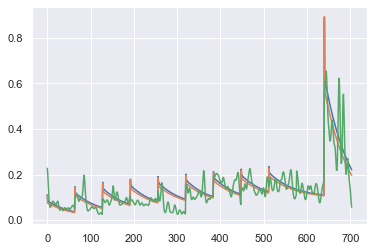

In [76]:
participant = 15
plt.plot(model_errors_six[0][participant])
plt.plot(model_errors_dual[0][participant])
plt.plot(np.ravel(curvatures_smooth[participant][1:]))

In [6]:
ll_dual = np.zeros((100, 60, 704))
ll_single = np.zeros((100, 60, 704))
ll_mix = np.zeros((100, 60, 704))
ll_six = np.zeros((100, 60, 704))

for i in range(100):
    for participant in range(60):
        ll_dual[i][participant] = stat.norm.logpdf(np.ravel(curvatures_smooth[participant][1:]), model_errors_dual[i][participant], fits_dual[i][participant, -2])
        ll_single[i][participant] = stat.norm.logpdf(np.ravel(curvatures_smooth[participant][1:]), model_errors_single[i][participant], fits_single[i][participant, -2])
        ll_mix[i][participant] = stat.norm.logpdf(np.ravel(curvatures_smooth[participant][1:]), model_errors_mixed[i][participant], fits_mixed[i][participant, -2])
        ll_six[i][participant] = stat.norm.logpdf(np.ravel(curvatures_smooth[participant][1:]), model_errors_six[i][participant], fits_six[i][participant, -2])
        #ll_six[i][participant] = stat.norm.logpdf(np.ravel(curvatures_smooth[participant][1:]), model_errors_six[i][participant], fits_dual[i][participant, -2])


In [113]:
def get_lls(fits, ll):
    ll_rotate_train = np.zeros((100, 60))
    ll_transfer_train = np.zeros((100, 60))
    ll_rotate_test = np.zeros((100, 60))
    ll_transfer_test = np.zeros((100, 60))
    ll_all_test = np.zeros((100, 60))
    ll_all_train = np.zeros((100, 60))

    for i in range(100):
        for participant in range(60):
            rotate_train_indices = fits[i][participant, -1][fits[i][participant, -1] < 640]
            transfer_train_indices = fits[i][participant, -1][fits[i][participant, -1] >= 640]

            all_test_indices = np.delete(range(704), fits[i][participant, -1])
            rotate_test_indices = all_test_indices[all_test_indices<640]
            transfer_test_indices = all_test_indices[all_test_indices>=640]

            ll_rotate_train[i][participant] = sum(ll[i][participant][rotate_train_indices])
            ll_transfer_train[i][participant] = sum(ll[i][participant][transfer_train_indices])
            ll_rotate_test[i][participant] = sum(ll[i][participant][rotate_test_indices])
            ll_transfer_test[i][participant] = sum(ll[i][participant][transfer_test_indices])
            ll_all_test[i][participant] = sum(ll[i][participant][all_test_indices])
            ll_all_train[i][participant] = sum(ll[i][participant][fits[i][participant, -1]])
            
    return (ll_rotate_train, ll_rotate_test, ll_transfer_train, ll_transfer_test, ll_all_train, ll_all_test)

In [114]:
dual_ll_rotate_train, dual_ll_rotate_test, dual_ll_transfer_train, dual_ll_transfer_test, dual_ll_all_train, dual_ll_all_test = get_lls(fits_dual, ll_dual)
single_ll_rotate_train, single_ll_rotate_test, single_ll_transfer_train, single_ll_transfer_test, single_ll_all_train, single_ll_all_test = get_lls(fits_single, ll_single)
mix_ll_rotate_train, mix_ll_rotate_test, mix_ll_transfer_train,  mix_ll_transfer_test, mix_ll_all_train, mix_ll_all_test = get_lls(fits_mixed, ll_mix)
six_ll_rotate_train, six_ll_rotate_test, six_ll_transfer_train, six_ll_transfer_test, six_ll_all_train, six_ll_all_test = get_lls(fits_six, ll_six)
#six_ll_rotate_train, six_ll_rotate_test, six_ll_transfer_train, six_ll_transfer_test, six_ll_all_train, six_ll_all_test = get_lls(fits_six, ll_six)


In [112]:
sum(ll_six[1][38]), sum(ll_dual[1][38])

(523.455905089142, 512.3707048493673)

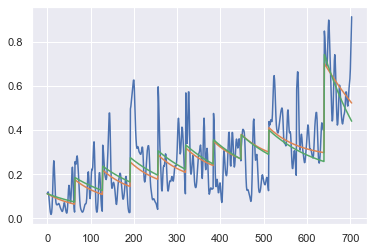

In [109]:
plt.plot(np.ravel(curvatures_smooth[38][1:]))
plt.plot(model_errors_six[1][38])
plt.plot(model_errors_dual[1][38])


In [32]:
for i in range(100):
    for participant in range(60):
        if six_ll_rotate_train[i][participant] > 10000:
            print ('Here in participant', participant, 'fit ', i)
            six_ll_rotate_train[i][participant] = dual_ll_rotate_train[i][participant]

In [115]:
dual_lls = np.array([dual_ll_rotate_train,  dual_ll_rotate_test, dual_ll_transfer_train, dual_ll_transfer_test, dual_ll_all_train, dual_ll_all_test])
single_lls = [single_ll_rotate_train, single_ll_rotate_test, single_ll_transfer_train, single_ll_transfer_test, single_ll_all_train, single_ll_all_test]
mix_lls = [mix_ll_rotate_train, mix_ll_rotate_test, mix_ll_transfer_train, mix_ll_transfer_test, mix_ll_all_train, mix_ll_all_test]
six_lls = np.array([six_ll_rotate_train, six_ll_rotate_test, six_ll_transfer_train, six_ll_transfer_test, six_ll_all_train, six_ll_all_test])

In [116]:
def get_full_split_df(ll_selected, ll_compared, selected_model):
    d = {'Rotation': np.ravel(np.row_stack((np.repeat('Sudden', 120), np.repeat('Gradual', 120)))),
         'Emphasis': np.ravel(np.row_stack((np.repeat('Speed', 60), np.repeat('Accuracy', 60), np.repeat('Speed', 60), np.repeat('Accuracy', 60)))),
         'Phase': np.ravel(np.row_stack((np.repeat('Rotate', 30), np.repeat('Transfer', 30), np.repeat('Rotate', 30), np.repeat('Transfer', 30), np.repeat('Rotate', 30), np.repeat('Transfer', 30), np.repeat('Rotate', 30), np.repeat('Transfer', 30)))),
         'Set': np.ravel(np.row_stack((np.repeat('Train', 15), np.repeat('Test', 15), np.repeat('Train', 15), np.repeat('Test', 15), np.repeat('Train', 15), np.repeat('Test', 15), np.repeat('Train', 15), np.repeat('Test', 15), (np.repeat('Train', 15), np.repeat('Test', 15), np.repeat('Train', 15), np.repeat('Test', 15), np.repeat('Train', 15), np.repeat('Test', 15), np.repeat('Train', 15), np.repeat('Test', 15)))))}
    df = pd.DataFrame(d)

    df[selected_model] = np.concatenate((
    sum(ll_compared[0][:, 0::4] <= ll_selected[0][:, 0::4]), 
    sum(ll_compared[1][:, 0::4] <= ll_selected[1][:, 0::4]),
    sum(ll_compared[2][:, 0::4] <= ll_selected[2][:, 0::4]),
    sum(ll_compared[3][:, 0::4] <= ll_selected[3][:, 0::4]),

    sum(ll_compared[0][:, 1::4] <= ll_selected[0][:, 1::4]), 
    sum(ll_compared[1][:, 1::4] <= ll_selected[1][:, 1::4]),
    sum(ll_compared[2][:, 1::4] <= ll_selected[2][:, 1::4]),
    sum(ll_compared[3][:, 1::4] <= ll_selected[3][:, 1::4]),

    sum(ll_compared[0][:, 2::4] <= ll_selected[0][:, 2::4]), 
    sum(ll_compared[1][:, 2::4] <= ll_selected[1][:, 2::4]),
    sum(ll_compared[2][:, 2::4] <= ll_selected[2][:, 2::4]),
    sum(ll_compared[3][:, 2::4] <= ll_selected[3][:, 2::4]),

    sum(ll_compared[0][:, 3::4] <= ll_selected[0][:, 3::4]), 
    sum(ll_compared[1][:, 3::4] <= ll_selected[1][:, 3::4]),
    sum(ll_compared[2][:, 3::4] <= ll_selected[2][:, 3::4]),
    sum(ll_compared[3][:, 3::4] <= ll_selected[3][:, 3::4])
    ))
    return df

In [117]:
def get_train_test_split(ll_selected, ll_compared, model_selected):
    d = {'Rotation': np.ravel(np.row_stack((np.repeat('Sudden', 60), np.repeat('Gradual', 60)))),
     'Emphasis': np.ravel(np.row_stack((np.repeat('Speed', 30), np.repeat('Accuracy', 30), np.repeat('Speed', 30), np.repeat('Accuracy', 30)))),
     'Set': np.ravel(np.row_stack((np.repeat('Train', 15), np.repeat('Test', 15), np.repeat('Train', 15), np.repeat('Test', 15), np.repeat('Train', 15), np.repeat('Test', 15), np.repeat('Train', 15), np.repeat('Test', 15))))}
    df = pd.DataFrame(d)
    df[model_selected] = np.concatenate((
    sum(ll_compared[4][:, 0::4] <= ll_selected[4][:, 0::4]), 
    sum(ll_compared[5][:, 0::4] <= ll_selected[5][:, 0::4]),

    sum(ll_compared[4][:, 1::4] <= ll_selected[4][:, 1::4]), 
    sum(ll_compared[5][:, 1::4] <= ll_selected[5][:, 1::4]),

    sum(ll_compared[4][:, 2::4] <= ll_selected[4][:, 2::4]), 
    sum(ll_compared[5][:, 2::4] <= ll_selected[5][:, 2::4]),

    sum(ll_compared[4][:, 3::4] <= ll_selected[4][:, 3::4]), 
    sum(ll_compared[5][:, 3::4] <= ll_selected[5][:, 3::4]),
    ))
    return df

In [149]:
df_full_split = get_full_split_df(six_lls, dual_lls, "Six_Selected")
df_train_test = get_train_test_split(six_lls, dual_lls, "Six_Selected")

Text(0.5, 0.98, 'Compared to Dual')

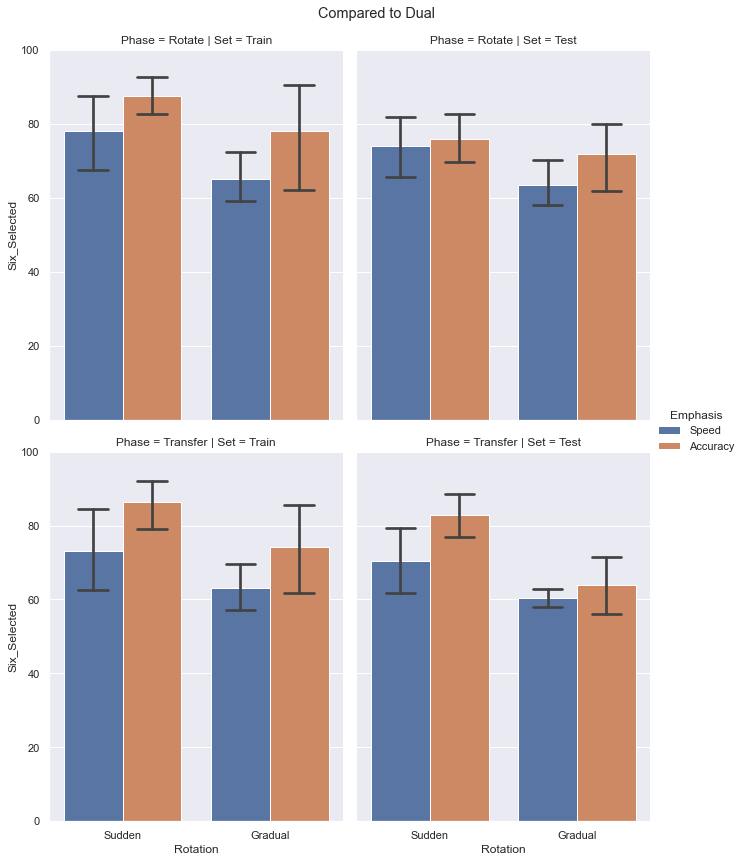

In [150]:
g = sns.catplot(x="Rotation", y="Six_Selected", hue="Emphasis", col="Set", row = "Phase",
                capsize=.2, height=6, aspect=.75,ci = 95,
                kind = 'bar', data=df_full_split)
plt.subplots_adjust(top=0.93)
plt.ylim((0, 100))
g.fig.suptitle('Compared to Dual')


Text(0.5, 0.98, 'Compared to Single')

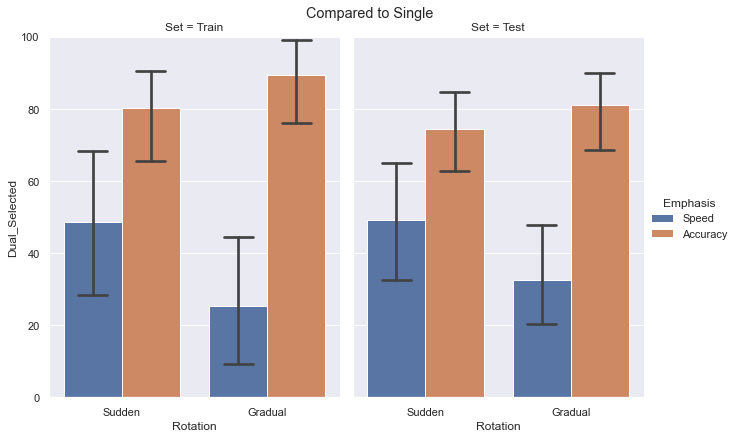

In [140]:
g = sns.catplot(x="Rotation", y="Dual_Selected", hue="Emphasis", col="Set", 
                capsize=.2, height=6, aspect=.75,ci = 95,
                kind = 'bar', data=df_train_test)
plt.subplots_adjust(top=0.91)
plt.ylim((0, 100))
g.fig.suptitle('Compared to Single')


In [56]:
model = smf.ols('Mix_Selected ~ Rotation*Emphasis*Phase', data=df_full_split[df_full_split['Set'] == 'Test']).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
Rotation,249.408333,1.0,0.260110,0.611013
Phase,8085.208333,1.0,8.432140,0.004414
Rotation:Phase,3488.408333,1.0,3.638094,0.058944
Residual,111227.300000,116.0,NaN,NaN


In [49]:
df_full_split[df_full_split['Phase'] == 'Rotate'][df_full_split['Set'] == 'Test']

<ipython-input-49-61550d84ba00>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_full_split[df_full_split['Phase'] == 'Rotate'][ df_full_split['Set'] == 'Test']


,Rotation,Emphasis,Phase,Set,Mix_Selected
15,Sudden,Speed,Rotate,Test,58
16,Sudden,Speed,Rotate,Test,11
17,Sudden,Speed,Rotate,Test,79
18,Sudden,Speed,Rotate,Test,33
19,Sudden,Speed,Rotate,Test,25
20,Sudden,Speed,Rotate,Test,100
21,Sudden,Speed,Rotate,Test,17
22,Sudden,Speed,Rotate,Test,74
23,Sudden,Speed,Rotate,Test,9
24,Sudden,Speed,Rotate,Test,89


In [144]:
dual_lls[0][:, 0::4] < 


(100, 15)

In [29]:
groupwise_wide = pd.DataFrame({'SS': np.sum(ll_single_test < ll_dual_test, axis = 0)[0::4],
                               'SA':np.sum(ll_single_test < ll_dual_test, axis = 0)[1::4],
                               'GS':np.sum(ll_single_test < ll_dual_test, axis = 0)[2::4],
                               'GA':np.sum(ll_single_test < ll_dual_test, axis = 0)[3::4]})
groupwise_long = pd.melt(groupwise_wide, var_name="Group", value_name="Dual_Selected")
groupwise_aov = pd.DataFrame({'Rotation': np.ravel(np.row_stack((np.repeat('Sudden', 30), np.repeat('Gradual', 30)))),
                             'Emphasis': np.ravel(np.row_stack((np.repeat('Speed', 15), np.repeat('Accuracy', 15), np.repeat('Speed', 15), np.repeat('Accuracy', 15)))),
                              'Dual_Selects': np.ravel(np.row_stack((np.sum(ll_single_test < ll_dual_test, axis = 0)[0::4], np.sum(ll_single_test < ll_dual_test, axis = 0)[1::4], np.sum(ll_single_test < ll_dual_test, axis = 0)[2::4], np.sum(ll_single_test < ll_dual_test, axis = 0)[3::4])))
                             })

IndexError: invalid index to scalar variable.

<AxesSubplot:xlabel='Group', ylabel='Dual_Selected'>

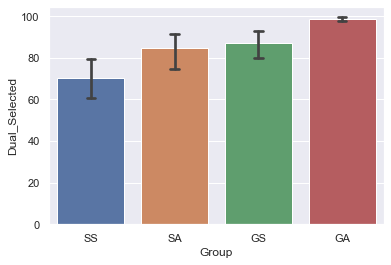

In [166]:
sns.barplot(x = 'Group', y = "Dual_Selected", data=groupwise_long, capsize=0.1)

In [189]:
model = smf.ols('Dual_Selects ~ Rotation*Emphasis', data=groupwise_aov).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
Rotation,3572.816667,1.0,16.885907,0.000131
Emphasis,2444.816667,1.0,11.554734,0.001251
Rotation:Emphasis,22.816667,1.0,0.107837,0.743846
Residual,11848.800000,56.0,NaN,NaN


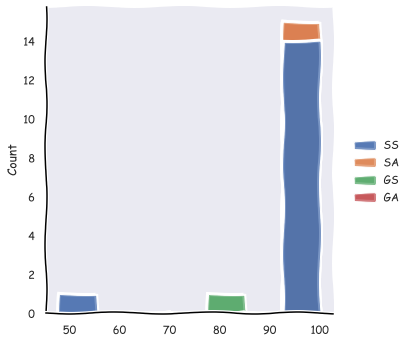

In [153]:
with plt.xkcd():
    sns.displot(groupwise_wide)


In [128]:
train_indices_704 = np.zeros((100, 60), dtype = object)
for i in range(100):
    for participant in range(60):
        train_indices_704[i][participant] = np.random.choice(704, 634, replace = False)
pickle.dump(train_indices_704, open('train_indices_704.pickle', 'wb'))

In [127]:
#ti7 = pickle.load(open('train_indices_704.pickle', 'rb'))

len(ti7)

100

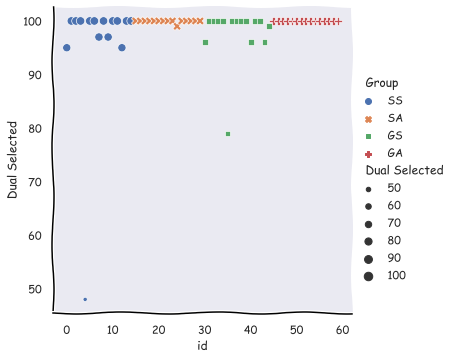

In [156]:
with plt.xkcd():
    sns.relplot(x = 'id', y = 'Dual Selected', hue = 'Group', size = 'Dual Selected', style = 'Group', data = groupwise_long)

Selecting Single state model: Overall
LLs on Test:  [66 17 13  1 35 13  0  0  6 14 10  1 32 27  8  1 60 13  6  0  6  0 27  1
 37  0  0  5 28 33 23  0 30 14  6  2 12 10  7  0  8  0 49  0 20 66 19  0
 42 12  2  0  7 10 16  3 53  3  6  5]
Selecting Single state model: 
LLs on Test:  [17 13 14 27 13  0  0 33 14 10  0 66 12 10  3]


50.24349663838527

In [29]:
r2_score(np.ravel(model_errors_dual), np.ravel(curvatures_smooth[:, 1:]))

-1.8435942015295161

In [30]:
r2_score(np.ravel(model_errors_single), np.ravel(curvatures_smooth[:, 1:]))

-1.7878687798910495

In [61]:
from scipy.ndimage import gaussian_filter1d
curvatures_smooth = gaussian_filter1d(curvatures, sigma = 2)
pickle.dump(curvatures_smooth, open('curvatures_smooth.pickle', 'wb'))

In [312]:
pval_dual.nonzero()

(array([ 0,  2,  4, 10, 13, 14, 16, 18, 24, 27, 28, 29, 30, 32, 34, 38, 40,
        42, 44, 45, 46, 48, 56, 58], dtype=int64),)

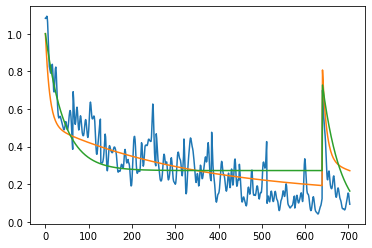

In [58]:
participant = 25
plt.plot(np.ravel(curvatures_smooth[participant][1:]))
plt.plot(model_errors_dual[participant])
plt.plot(model_errors_single[participant])

In [47]:
fits_dual[0, 5]

10.503401873917536

In [49]:
fits_single[0, 3]

-82.73038327528457

93.2337851492021